In [1]:
import numpy as np
# from scipy.interpolate import interp1d
# from scipy.optimize import bisect
# from tqdm.notebook import tqdm,trange


import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

# Setup

In [2]:
def step_Euler(func,t0,q0,h):
    t1 = t0 + h
    q1 = q0 + h*func(q0,t0)
    return t1,q1,h

In [3]:
def step_RKF45(func,t0,q0,h,tol,adaptive=True):
    A = np.array([
        [0,0,0,0,0,0],
        [1/4,0,0,0,0,0],
        [3/32,9/32,0,0,0,0],
        [1932/2197,-7200/2197,7296/2197,0,0,0],
        [439/216,-8,3680/513,-845/4104,0,0],
        [-8/27,2,-3544/2565,1859/4104,-11/40,0]
    ])
    B = np.array([0,1/4,3/8,12/13,1,1/2])
    
    K   = np.zeros((6,q0.shape[0]))
    for i in range(6):
        K[i] = h*func(q0+np.einsum('i,ij',A[i],K),t0+B[i]*h)
    
    t1  = t0 + h
    C   = np.array([16/135,0,6656/12825,28561/56430,-9/50,2/55])
    q1  = q0 + np.einsum('i,ij',C,K)
    
    D   = np.array([1/360,0,-128/4275,-2197/75240,1/50,2/55])
    err = np.abs(max(np.einsum('i,ij',D,K) + 1e-100)) # possibly change
    
    if err < tol or not adaptive:
        if adaptive:
            h1 = min(0.9*h*(tol/err)**(1/6),2*h)
        else:
            h1 = h
        return t1,q1,h1
    else:
        h1 = min(0.9*h*(tol/err)**(1/6),h/2)
        return step_RKF45(func,t0,q0,h1,tol)

In [4]:
def solve_ODE(func,t0,q0,h,stop=lambda t_res,q_res: False,tol=1e-4,method='RKF45',max_iter=int(1e3),adaptive=True):
    if method == 'RKF45':
        step_func = lambda t0_,q0_,h_: step_RKF45(func,t0_,q0_,h_,tol,adaptive)
    elif method == 'modified Euler':
        step_func = lambda t0_,q0_,h_: step_mod_Euler(func,t0_,q0_,h_)
    elif method == 'Euler':
        step_func = lambda t0_,q0_,h_: step_Euler(func,t0_,q0_,h_)
    
    t_results = [t0]
    q_results = [q0]
    for i in range(max_iter):
        t1,q1,h = step_func(t_results[-1],q_results[-1],h)
        t_results.append(t1)
        q_results.append(q1)
        
        if stop(t_results,q_results):
            break
            
    return np.array(t_results),np.array(q_results)

In [5]:
# x  = np.linspace(1,10,1000)
# F_ = np.array([F_coulomb(np.array([_,0]),np.array([0,0])) for _ in x])

# plt.plot(x,F_.T[0])
# plt.show()

In [58]:
def F_coulomb(x1,x2,Z1=1,Z2=1):
    k = 8.9875517923e9
    return Z1*Z2*(x1 - x2)/np.sum((x1 - x2)**2)**(3/2)

# Part 1 -- fixed target at origin

In [59]:
def f(q,t,m1=1,Z1=1,Z2=2):
    return np.array([*q[2:],*F_coulomb(q[:2],np.array([0,0]),Z1,Z2)/m1])

### Test

In [60]:
x0 = -50
b  = 1
v0 = 1
q0 = np.array([x0,b,v0,0])

t0 = 0
tf = 10
N = 100
h = (tf - t0)/N

def stop(t_res,q_res,atol=1e-6,rtol=1e-6):
    th_p  = np.arctan(q_res[-2][3]/q_res[-2][2])
    th_c  = np.arctan(q_res[-1][3]/q_res[-1][2])
    cond1 = np.abs(th_p - th_c) < atol or np.abs(1 - th_c/(th_p + 1e-100)) < rtol
    cond2 = np.sum(q_res[-1][:2]**2) - np.sum(q_res[0][:2]**2) > 0
    
    return cond1 and cond2

In [61]:
t,q = solve_ODE(f,t0,q0,h,stop,method='Euler',tol=1e-10,adaptive=True)    
x,y,vx,vy = q.T

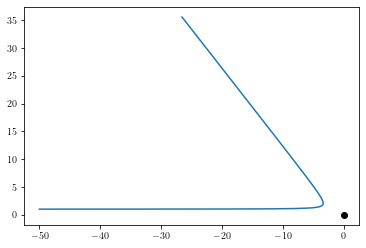

In [62]:
plt.plot(x,y)
plt.plot([0],[0],color='k',marker='o')
plt.show()

### calculate $b(\theta)$

In [63]:
b = np.linspace(0.1,10,100)
q_results = np.zeros((b.shape[0],4))
for i in range(b.shape[0]):
    q0 = np.array([x0,b[i],v0,0])
    t,q = solve_ODE(f,t0,q0,h,stop,method='RKF45',tol=1e-10,adaptive=True)
    q_results[i] = q[-1]
    
#     x,y,vx,vy = q.T
#     plt.plot(x,y)
# plt.show()

theta = np.arctan2(q_results[:,3],q_results[:,2])

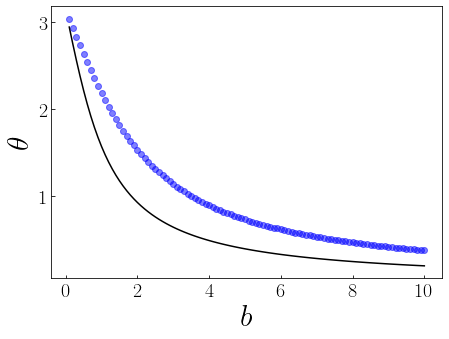

In [71]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7*ncols,5*nrows))

ax.plot(b,theta,ls='None',marker='o',color='b',alpha=0.5)

ax.set_xlabel(r'$b$',size=30)
ax.set_ylabel(r'$\theta$',size=30)
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)

exact = 2*np.arctan(Z1*Z2/b/m1/v0**2)
ax.plot(b,exact,'k-')


plt.show()

In [21]:
def get_derivative(x,y):
    temp = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    temp = np.append(temp,temp[-1])
    return temp

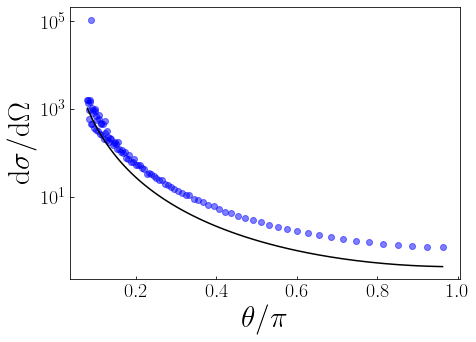

In [22]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7*ncols,5*nrows))

dsig = b/np.sin(theta)/np.abs(get_derivative(b,theta))
ax.plot(theta/np.pi,dsig,ls='None',marker='o',color='b',alpha=0.5)

ax.set_xlabel(r'$\theta/\pi$',size=30)
ax.set_ylabel(r'${\rm d} \sigma / {\rm d} \Omega$',size=30)
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.semilogy()

Z1,Z2 = 1,1
m1    = 1
exact = (Z1*Z2/4/(m1*v0**2/2)/np.sin(theta/2)**2)**2
plt.plot(theta/np.pi,exact,'k-')


plt.show()

# Part 2 -- moving target

In [ ]:
def f(q,t,m1=1,m2=1,Z1=1,Z2=2):
    F_ = F_coulomb(q[:2],q[4:6],Z1,Z2)
    return np.array([*q[2:4],*F_/m1,*q[6:8],*(-F_/m2)])

In [ ]:
x0 = -5
b  = 0.1
v0 = 10
q0 = np.array([x0,b,v0,0,0,0,0,0])

t0 = 0
tf = 10
N = 100
h = (tf - t0)/N

In [ ]:
t,q = solve_ODE(f,t0,q0,h,stop,method='RKF45',adaptive=False)
x1,y1,vx1,vy1,x2,y2,vx2,vy2 = q.T

In [ ]:
plt.plot(x1,y1)
plt.plot(*[x0,b],color='k',marker='o')

plt.plot(x2,y2)
plt.plot(*[0,0],color='k',marker='o')

plt.show()